# **CIFAR 10 Dataset - CNN**

In [1]:
import torch
import torch.nn as nn
from torch import FloatTensor, LongTensor
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

## *Data Augmentation & Processing*

In [2]:
transform = transforms.Compose(
    [
        transforms.RandomRotation(degrees = 45),
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])
    ]
)

In [3]:
train_data = datasets.CIFAR10(root = "data", train = True, transform = transform, download = True)
test_data = datasets.CIFAR10(root = "data", train = False, transform = transform, download = True)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
train_data, test_data

(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: data
     Split: Train
     StandardTransform
 Transform: Compose(
                RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
                Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
                Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
            ),
 Dataset CIFAR10
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: Compose(
                RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
                Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
                Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
            ))

In [5]:
train_data[0][0].shape

torch.Size([3, 32, 32])

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
from random import randint

fig = plt.figure(figsize = (80, 200))

for i in range(50):
  fig.add_subplot(10, 5, i + 1)
  random_num = randint(0, 50000)
  plt.imshow(train_data[random_num][0].detach().numpy().transpose(2, 1, 0))
  plt.title(f"Label : {train_data[random_num][1]}", fontdict = {"fontsize" : 100})

## *Playing With Convolution & Pooling Layers.....*

In [8]:
conv1 = nn.Conv2d(
    in_channels = 3,
    out_channels = 6,
    kernel_size = 5,
    stride = 1,
    padding = 0
  )

conv2 = nn.Conv2d(
    in_channels = 6,
    out_channels = 16,
    kernel_size = 5,
    stride = 1,
    padding = 0
  )

max_pool = nn.MaxPool2d(
    kernel_size = 2,
    stride = 2,
    padding = 0
  )

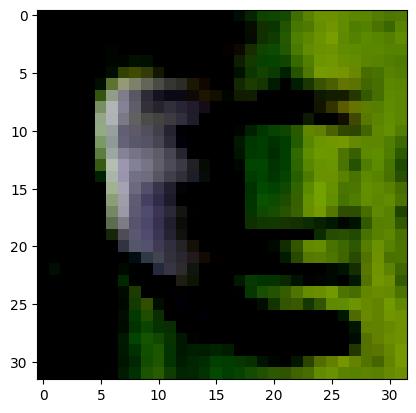

In [9]:
random_num = 87
plt.imshow(train_data[random_num][0].detach().numpy().transpose(2, 1, 0))

In [10]:
ReLU = nn.ReLU()

x = conv1(train_data[random_num][0])
x = ReLU(x)
x = max_pool(x)
x = conv2(x)
x = ReLU(x)
x = max_pool(x)

x.shape

torch.Size([16, 5, 5])

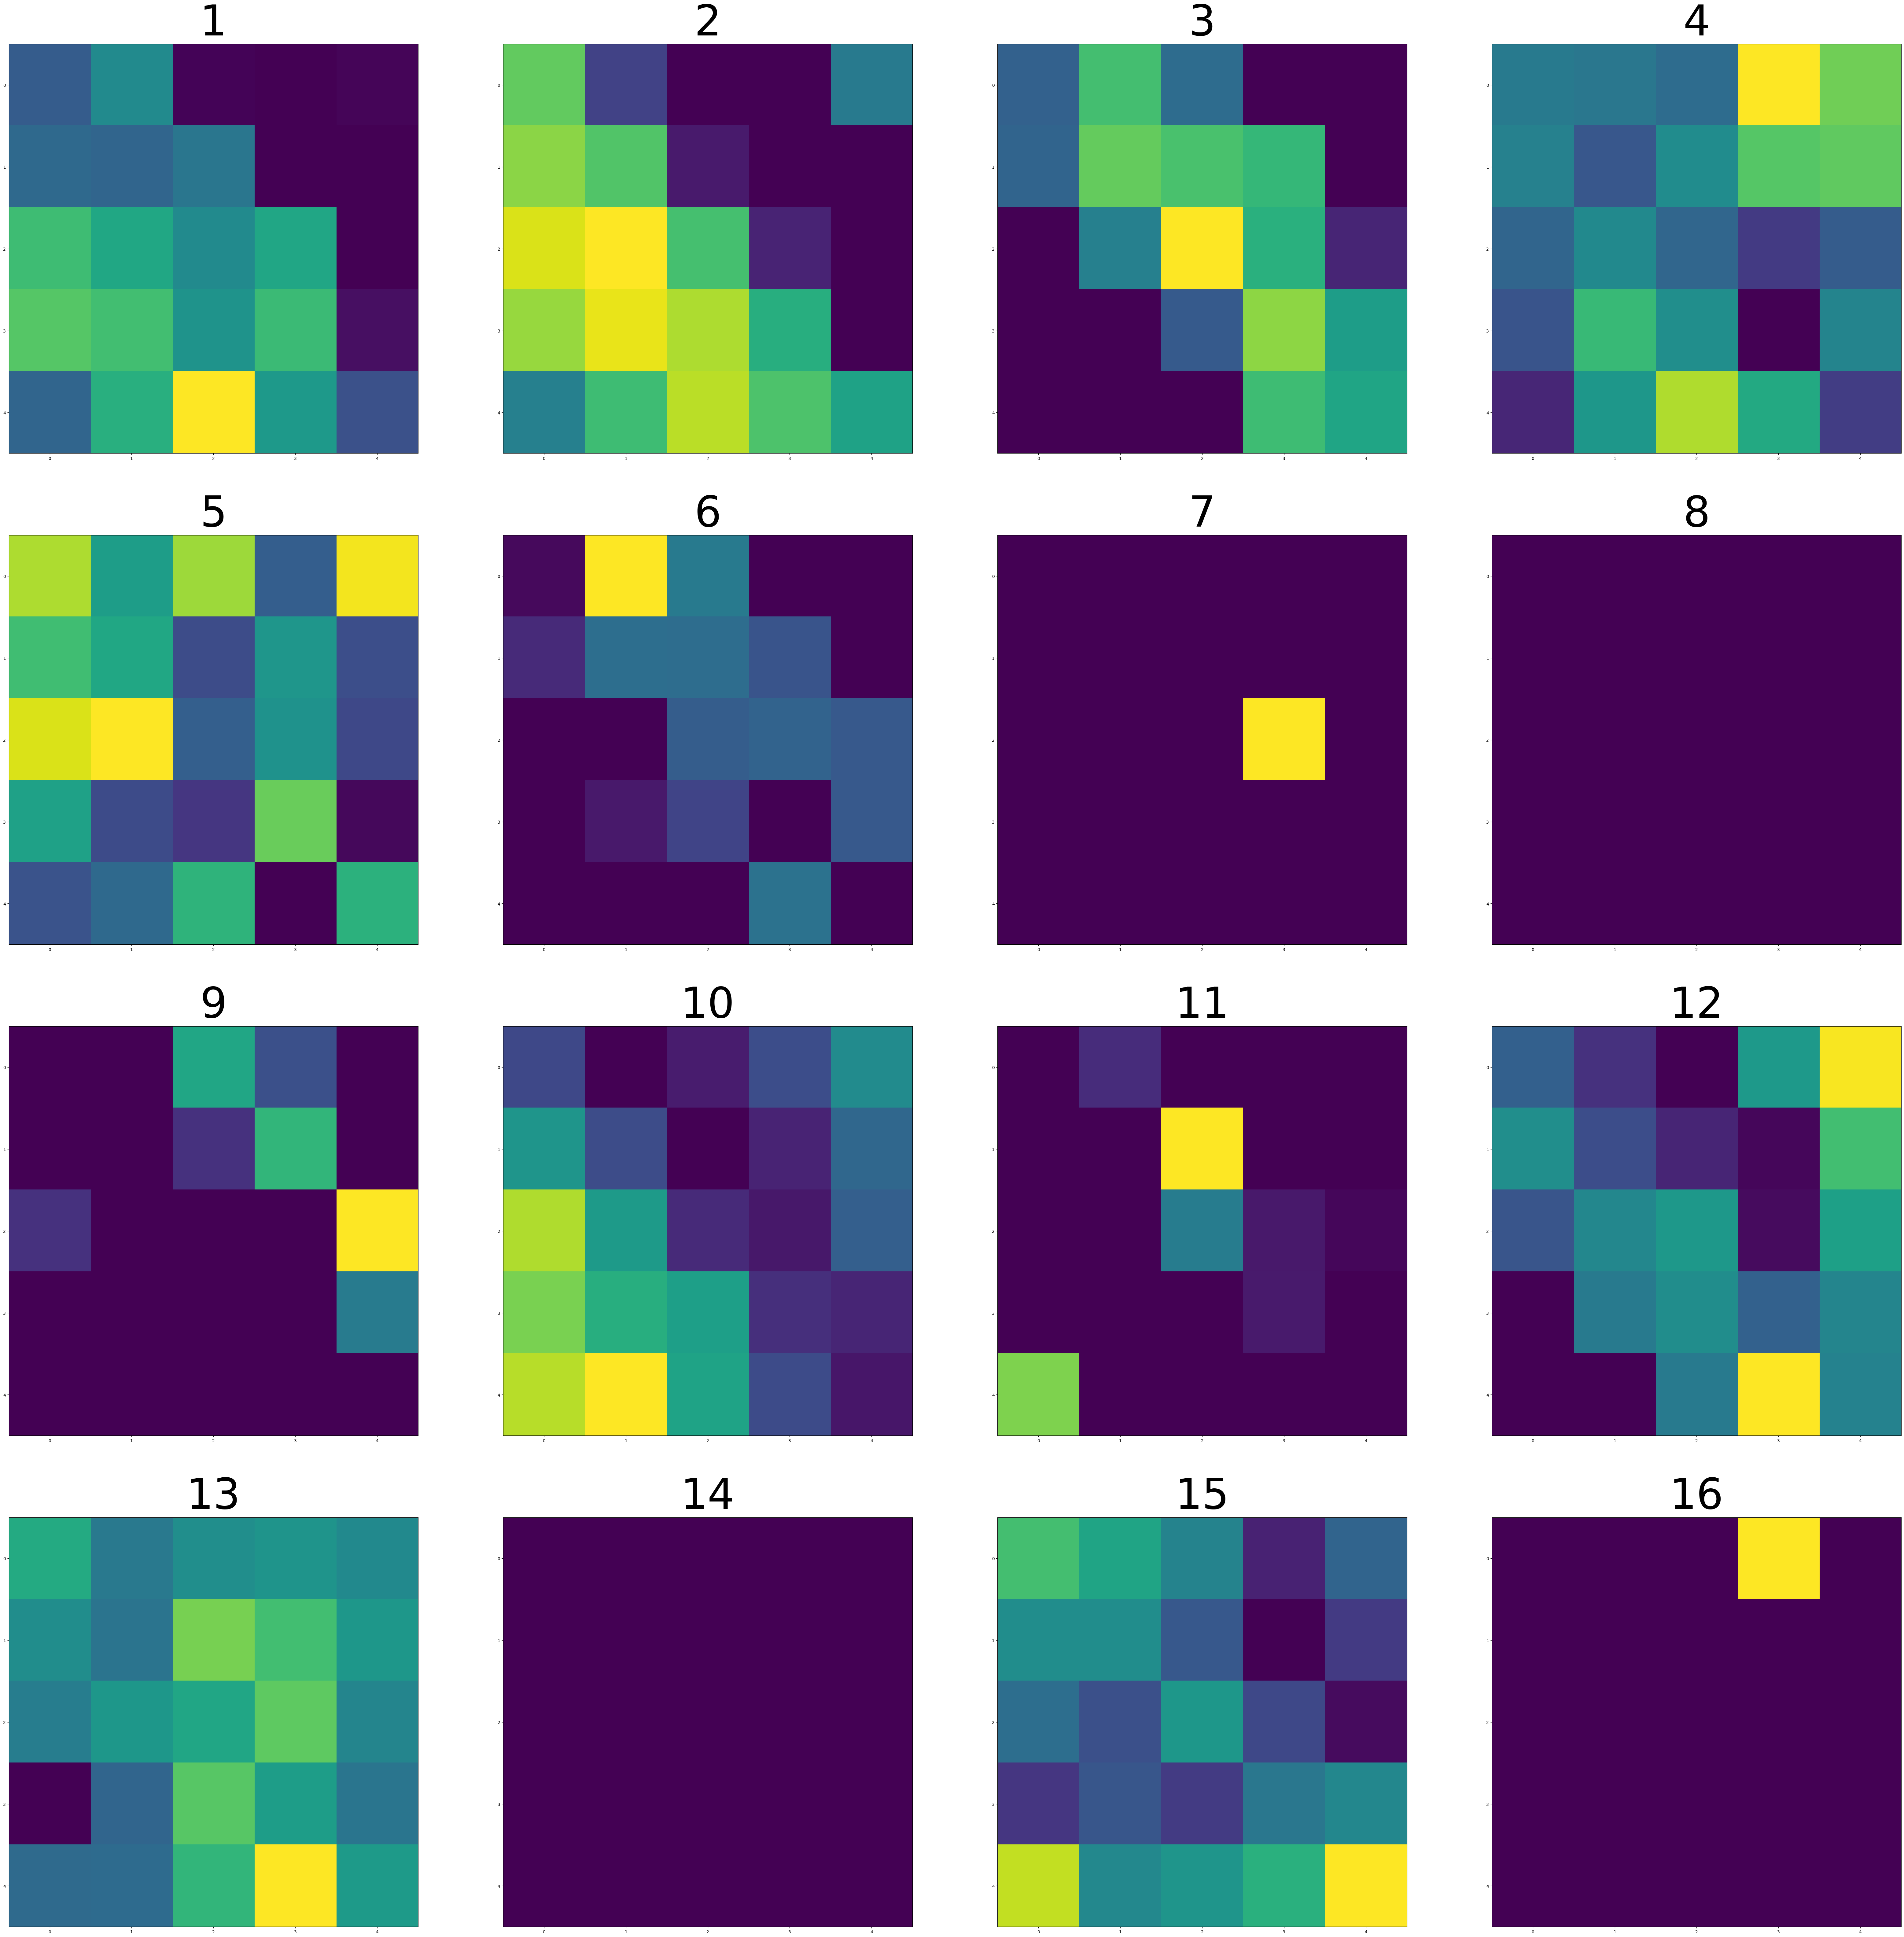

In [11]:
fig = plt.figure(figsize = (80, 80))

for i in range(x.shape[0]):
  fig.add_subplot(4, 4, i + 1)
  plt.imshow(x[i].detach().numpy())
  plt.title(f"{i + 1}", fontdict = {"fontsize" : 100})

In [12]:
train_loader = DataLoader(train_data, batch_size = 20, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 20, shuffle = True)

## *Creating The CNN*

In [13]:
class CNN(nn.Module):

  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(
        in_channels = 3,
        out_channels = 9,
        kernel_size = 5,
        stride = 1,
        padding = 0
    )

    self.conv2 = nn.Conv2d(
        in_channels = 9,
        out_channels = 16,
        kernel_size = 5,
        stride = 1,
        padding = 0
    )

    self.max_pool = nn.MaxPool2d(
        kernel_size = 2,
        stride = 2,
        padding = 0
    )

    self.flatten = nn.Flatten()

    self.fc1 = nn.Linear(16 * 5 * 5, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, 128)
    self.fc4 = nn.Linear(128, 128)
    self.fc5 = nn.Linear(128, 10)

    self.ReLU = nn.ReLU()

  def forward(self, x):
    x = self.conv1(x)
    x = self.ReLU(x)
    x = self.max_pool(x)
    x = self.conv2(x)
    x = self.ReLU(x)
    x = self.max_pool(x)

    x = self.flatten(x)

    x = self.fc1(x)
    x = self.ReLU(x)
    x = self.fc2(x)
    x = self.ReLU(x)
    x = self.fc3(x)
    x = self.ReLU(x)
    x = self.fc4(x)
    x = self.ReLU(x)
    x = self.fc5(x)

    return x

In [14]:
torch.manual_seed(42)

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## *Training The Model*

In [16]:
Model = CNN().to(device)

In [17]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(Model.parameters(), lr = 0.001)

In [18]:
epochs = 25

training_losses = []
testing_losses = []
training_accuracies = []
testing_accuracies = []

for epoch in range(epochs):

  Model.train()

  training_correct = 0
  for batch, (x_train, y_train) in enumerate(train_loader):
    x_train, y_train = x_train.to(device), y_train.to(device)

    y_pred = Model(x_train)
    loss = loss_fn(y_pred, y_train)

    training_correct += (torch.max(y_pred, 1)[1] == y_train).sum()
    training_losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (batch + 1) % 100 == 0:
      print(f"Epoch : {epoch + 1} | Batch : {batch + 1} | Loss : {loss.item()}")
  training_accuracies.append(training_correct / len(train_data))

  Model.eval()

  with torch.no_grad():
    testing_correct = 0
    for batch, (x_test, y_test) in enumerate(test_loader):
      x_test, y_test = x_test.to(device), y_test.to(device)

      y_pred = Model(x_test)
      loss = loss_fn(y_pred, y_test)

      testing_losses.append(loss.item())
      testing_correct += (torch.argmax(y_pred, 1) == y_test).sum()
      if (batch + 1) % 100 == 0:
        print(f"Epoch : {epoch + 1} | Validation Batch : {batch + 1} | Validation Loss : {loss.item()}")
    testing_accuracies.append(testing_correct / len(test_data))

  print(f"Epoch : {epoch + 1} | Training Acc : {training_accuracies[-1]} | Validation Acc : {testing_accuracies[-1]}")

Epoch : 1 | Batch : 100 | Loss : 1.8219778537750244
Epoch : 1 | Batch : 200 | Loss : 2.0022568702697754
Epoch : 1 | Batch : 300 | Loss : 2.050637722015381
Epoch : 1 | Batch : 400 | Loss : 1.8334033489227295
Epoch : 1 | Batch : 500 | Loss : 1.6387217044830322
Epoch : 1 | Batch : 600 | Loss : 1.6866495609283447
Epoch : 1 | Batch : 700 | Loss : 1.7805309295654297
Epoch : 1 | Batch : 800 | Loss : 1.7027580738067627
Epoch : 1 | Batch : 900 | Loss : 1.5396058559417725
Epoch : 1 | Batch : 1000 | Loss : 1.7269322872161865
Epoch : 1 | Batch : 1100 | Loss : 1.6261818408966064
Epoch : 1 | Batch : 1200 | Loss : 1.4067548513412476
Epoch : 1 | Batch : 1300 | Loss : 1.7731666564941406
Epoch : 1 | Batch : 1400 | Loss : 1.3001543283462524
Epoch : 1 | Batch : 1500 | Loss : 1.6234099864959717
Epoch : 1 | Batch : 1600 | Loss : 1.6940984725952148
Epoch : 1 | Batch : 1700 | Loss : 1.5075346231460571
Epoch : 1 | Batch : 1800 | Loss : 1.5542881488800049
Epoch : 1 | Batch : 1900 | Loss : 1.6193002462387085
Epo

## *Testing & Analysing The Model*

In [66]:
Model.eval()

correct = 0
y_testing = []
y_predicted = []

with torch.no_grad():
  for _, (x_test, y_test) in enumerate(test_loader):
    x_test, y_test = x_test.to(device), y_test.to(device)
    y_pred = torch.argmax(Model(x_test), 1)
    correct += (y_pred == y_test).sum()

    for i, j in zip(y_pred, y_test):
      y_predicted.append(i.cpu())
      y_testing.append(j.cpu())

print(f"Accuracy : {correct / 10000 * 100} %")

Accuracy : 62.97999572753906 %


In [68]:
from sklearn.metrics import classification_report
print(classification_report(y_pred = y_predicted, y_true = y_testing))

              precision    recall  f1-score   support

           0       0.65      0.71      0.68      1000
           1       0.68      0.80      0.74      1000
           2       0.52      0.57      0.55      1000
           3       0.45      0.45      0.45      1000
           4       0.56      0.60      0.58      1000
           5       0.59      0.45      0.51      1000
           6       0.69      0.69      0.69      1000
           7       0.68      0.66      0.67      1000
           8       0.72      0.75      0.74      1000
           9       0.76      0.60      0.67      1000

    accuracy                           0.63     10000
   macro avg       0.63      0.63      0.63     10000
weighted avg       0.63      0.63      0.63     10000



In [69]:
classes = (
    'plane',
    'car',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
  )

In [70]:
from random import randint

Model.eval()
fig = plt.figure(figsize = (80, 200))

for i in range(50):
  fig.add_subplot(10, 5, i + 1)
  plt.imshow(test_data[i + 1000][0].detach().numpy().transpose(2, 1, 0))

  with torch.no_grad():
    pred = Model(test_data[i + 1000][0].view(1, 3, 32, 32).to(device))
    pred = torch.argmax(pred, 1)[0]

  plt.title(f"True Label : {classes[test_data[i + 1000][1]]} \nPredicted Label : {classes[pred]}", fontdict = {"fontsize" : 80})

## *Saving The Model*

In [59]:
torch.save(Model.state_dict(), "CIFAR10_CNN.pt")